# Data Storage testing

In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import numpy as np
import numpy

import pandas as pd
import random
import os
import pickle
import matplotlib.pyplot as plt
#
import h5py

In [12]:
def make_random_data(numb_sim, numb_time_steps):
    return np.random.rand(numb_sim, numb_time_steps)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [20]:
DATA='data_storage_test'
data_path_h5 = 'data_h5'
fname_data = 'data_output.h5'

lost=[2, 4, 6, 9]
#
for pth in (DATA, data_path_h5):    
    if not os.path.isdir(pth):
        os.makedirs(pth)

In [15]:
print('** ', pd.__version__)

**  1.0.4


### Saving data with HDF5
- First, note that even just using numpy, datasets can be consolidated and saved as a 3D object, shape=(s, numb_sim, numb_time_steps)
- With HDF5, we can either create that object, then save it to HDF5, add to that object as we go, or save in a nested JSON-like structure {s:{sim:[data], ...}, ...}

In [134]:
#
#
# since number of sims and timesteps is not constan, we'll group on that.
fout_path = os.path.join(data_path_h5, fname_data)
#
with h5py.File(fout_path, 'w') as fout:
    n_iterations = 20
    im_x = 10
    im_y = 10
    #
    # instantiate a container for images.
    img_3d = fout.create_dataset(name='images_3d', shape=(n_iterations, im_y, im_x))
    # note also that we could .resize() the array as we go, or we could use any number of
    # other data shapes and organization.
    #
    for k_iter in range(n_iterations):

        if k_iter in lost:
            continue # sim didnt run
            # TODO: log jobs that failed to run.
        #
        grp = fout.create_group('experiment_{}'.format(k_iter))

        # numpy
        # number of MC-like simulations, and timesteps for each sim?
        numb_sim = random.randint(700, 1500)
        numb_time_steps = random.randint(8000, 15000)
        #
        # generate simulation data (in real life, this is obviously more complex):
        sim_data = make_random_data(numb_sim, numb_time_steps)
        # saving np
        #
        ds_np = grp.create_dataset('numpy', data=sim_data)
        #ds_np = grp.create_dataset('numpy', (numb_sim, numb_time_steps), dtype='>f8')
        #ds_np[:] = sim_data
        #np.save(os.path.join(DATA,'simulation_data_'+str(s)+'.npy'),sim_data)

        # pandas
        number_names_pandas=random.randint(7, 15)
        pandas_names = ['pandas_name_{}'.format(i) for i in range(number_names_pandas)]
        data_pandas=make_random_data(random.randint(700, 1500), number_names_pandas)
        #
        #df = pd.DataFrame.from_items(zip(pandas_names, data_pandas))
        #df = pd.DataFrame.from_dict(dict(zip(pandas_names, data_pandas)))
        # saving pandas
        #df.to_pickle(os.path.join(DATA,"pandas_"+str(s)+".pkl"))
        #ds_pd = grp.create_dataset('pandas', data=zip(pandas_names, data_pandas),
        #        dtype=[('name', 'S20')] + [('c_{}'.format(k), '>f8') for k in range(data_pandas.shape[1]) ])
        #
        # there must be a better, one-liner way to assign values and data-types, but I've yet to find it!
        #  I work around the syntax debackle by declaring the dataset object, then assigning values by column.
        ds_pd = grp.create_dataset('pandas', shape=(len(data_pandas),), 
                                   dtype=[(nm, 'f8') for nm in pandas_names])
        # note the assignment syntax, dataset[col][:]=vals, namely the [:]. It varies a bit, but this is often
        #. necessary for HDF5 and NetCDF objects to distinguish between assigning a pointer to that data
        #. vs actually assigning values. In some cases, if this is done incorrectly, it will look like the
        #. assignment was successful, but when you close and reopen the file, the values won't be there.
        for nm,cl in zip(pandas_names, data_pandas.T):
            ds_pd[nm][:] = cl
        #
        # You can create a numpy array with mixed types like this, but it delcares them as a 'U{x}'\
        #"universal??", which HDF5 does not understand. There is probably a trick to putting them together
        # but I've not found it yet.
        #dta = np.append( np.reshape(pandas_names, (-1,1)), data_pandas.T, axis=1)
        #
        # Then, in principle, you can create an indexed dataset like this, 
        # but for a braod table, the headers are too big (too many named columns).:
        # data_type = [('name','S20')] + [('cl_{}'.format(k), 'f8') for k in np.arange(data_pandas.shape[0]) ]
        # ds_pd_t = grp.create_dataset('pandas_t', shape=(len(pandas_names),),
        #                     dtype=data_type )
        # ds_pd_t['name'][:]=pandas_names
        # for k in range(data_pandas.shape[0]):
        #     ds_pd_t['cl_{}'.format(k)][1:]=data_pandas[k,1:]
        #
        # 
        # You could save the name labels as an attribute:
        ds_pd_2 = grp.create_dataset('pandas_nd', data=data_pandas.T)
        ds_pd_2.attrs.create(name='names', data=pandas_names)
        #
        # or note that you can do this more or less manually by creating a separate regular dataset
        # which is not necessarily directly associated with anything, and can be used as a joining table:
        ds_names = grp.create_dataset(name='pandas_names', shape=(len(pandas_names),),
                                      data=[s.encode() for s in pandas_names],
                                      dtype='S{}'.format(np.max([len(s) for s in pandas_names])))
        #
        # NOTE: there might be a better way to do this by saving the names as a dimension

# I'm going to skip the dict model, since ds_pd basically contains this solution, but better.
# Note that for some other cases, you can just save each dict key as an hdf5.group(), completely replicating
#. the dict format.
#. generally, I'd recommend using a numpy structured array (an array with dtpye defined and columns named)
#. or a numpy recarray -- which looks the same as a structured array, but turns out is not the same under
#  the hood. In recent versions, recarrays are a little bit easier to work with (in my experience), but numpy
#. arrays are supposed to perform much faster. I'd be surprised if they are not, very soon if not already, 
#  merged together on the back end, so that they really are identical.
#         # dict
#         number_names_dict=random.randint(10, 23)
#         dict_keys = ['key_name'+str(i) for i in range(number_names_dict)]
#         dict_={} #{x: [] for x in dict_keys}

#         for j in range(len(dict_keys)):

#             key=dict_keys[j]

#             if j%2==0:
#                 value=make_random_data(random.randint(700, 1500), random.randint(700, 1500))

#             if j==4:
#                 value='amazing'

#             else:
#                 value=make_random_data(random.randint(500, 1000), 1)


#             #dict_ = dict(zip(key, value))
#             dict_[key]=value

#         # save dict
#         save_obj(dict_, os.path.join(DATA,'dict_'+str(s)))


#         list_length = random.randint(10, 23)
#         list_ = ['a_name_'+str(i) for i in range(number_names_dict)]

#         # save list
#         save_obj(list_, os.path.join(DATA,'list_'+str(s)))

#         #image
#         ima = np.random.normal(0,3,100).reshape(10,10)
#         plt.imshow(ima)
#         plt.savefig(os.path.join(DATA,'test'+str(s)+'.png')
        # if images are the same size, you'd probably want to stack them into a 3D
        #. array (and dataset), shape=(n_images, n_y, n_x). Since we are generating images
        #. of random size, we can save those arrays separately. Note, a 3 color (RGB) images is
        #. a 3D array, usually either (3,n_y, n_x) or (n_y, n_x, 3)
        img_data = np.random.normal(0., 3., (im_y, im_x))
        ds_img = grp.create_dataset(name='image', data=img_data)
        #
        img_3d[k_iter,:] = img_data
            

    
    

### Reading the HDF5 object
- Open the file; read some of the data structure
- Some meta data maybe
- Some data?

Then open it again, plot some data. Show that some images were saved correctly.

In [135]:
print('** lost: ', lost)
with h5py.File(fout_path, 'r') as fin:
    print('** keys: ')
    #
    for ky,vl in fin.items():
        if not hasattr(vl, 'keys'):
            print('** DS {}: {}'.format(ky, vl.shape))
            print('** **')
            continue
        #
        print('** {}:: {}'.format(ky, vl.keys()))
        print('** **:: {}'.format([(k,v.size/1024) for k,v in vl.items()]))
        print('** **:: {}'.format([(k,v.shape) for k,v in vl.items()]))
        print('** ** **')
    #
    
#

** lost:  [2, 4, 6, 9]
** keys: 
** experiment_0:: <KeysViewHDF5 ['image', 'numpy', 'pandas', 'pandas_names', 'pandas_nd']>
** **:: [('image', 0.09765625), ('numpy', 10160.302734375), ('pandas', 1.404296875), ('pandas_names', 0.0107421875), ('pandas_nd', 15.447265625)]
** **:: [('image', (10, 10)), ('numpy', (834, 12475)), ('pandas', (1438,)), ('pandas_names', (11,)), ('pandas_nd', (11, 1438))]
** ** **
** experiment_1:: <KeysViewHDF5 ['image', 'numpy', 'pandas', 'pandas_names', 'pandas_nd']>
** **:: [('image', 0.09765625), ('numpy', 9165.92578125), ('pandas', 1.43359375), ('pandas_names', 0.009765625), ('pandas_nd', 14.3359375)]
** **:: [('image', (10, 10)), ('numpy', (812, 11559)), ('pandas', (1468,)), ('pandas_names', (10,)), ('pandas_nd', (10, 1468))]
** ** **
** experiment_10:: <KeysViewHDF5 ['image', 'numpy', 'pandas', 'pandas_names', 'pandas_nd']>
** **:: [('image', 0.09765625), ('numpy', 8727.017578125), ('pandas', 1.078125), ('pandas_names', 0.0068359375), ('pandas_nd', 7.5468

**  (945, 9397)


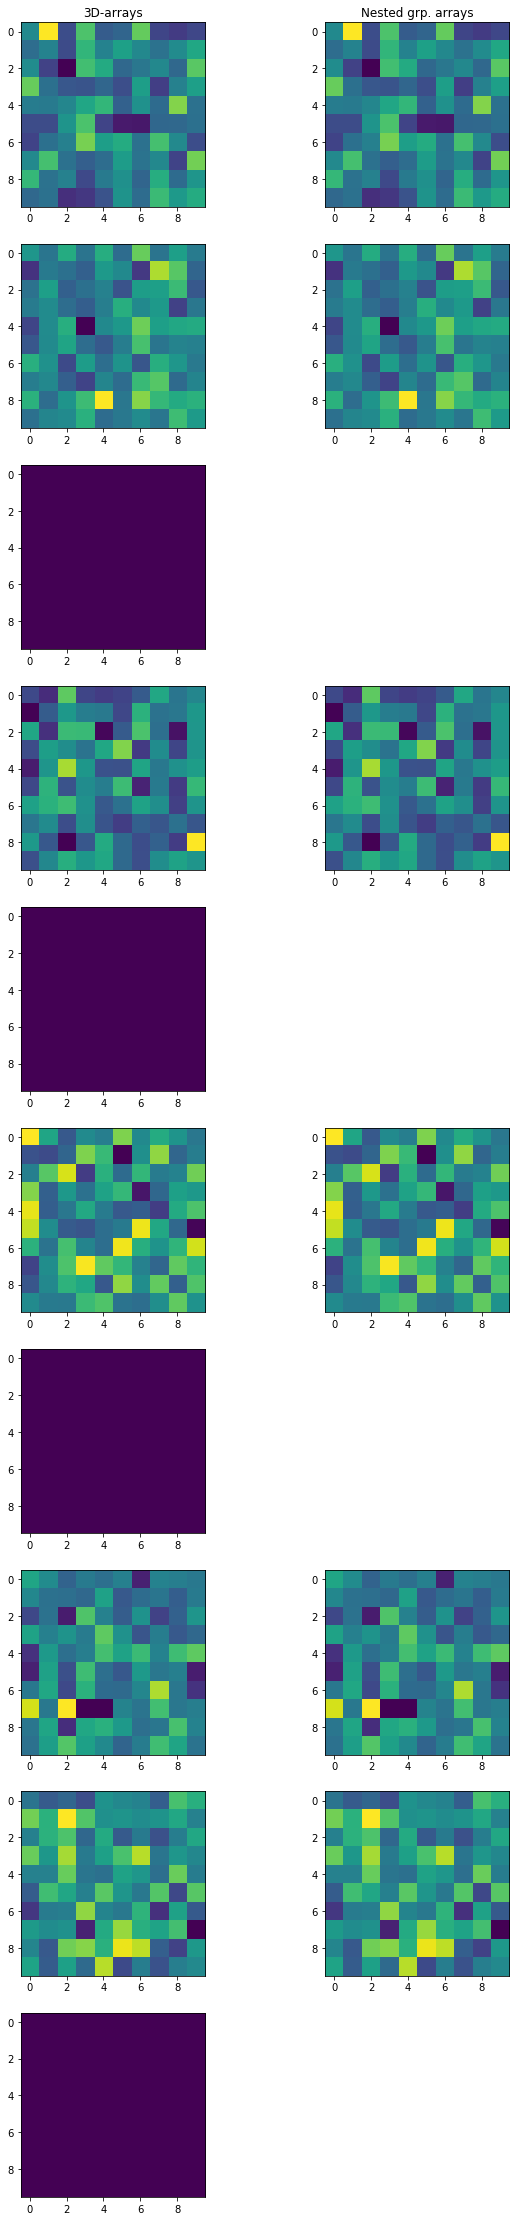

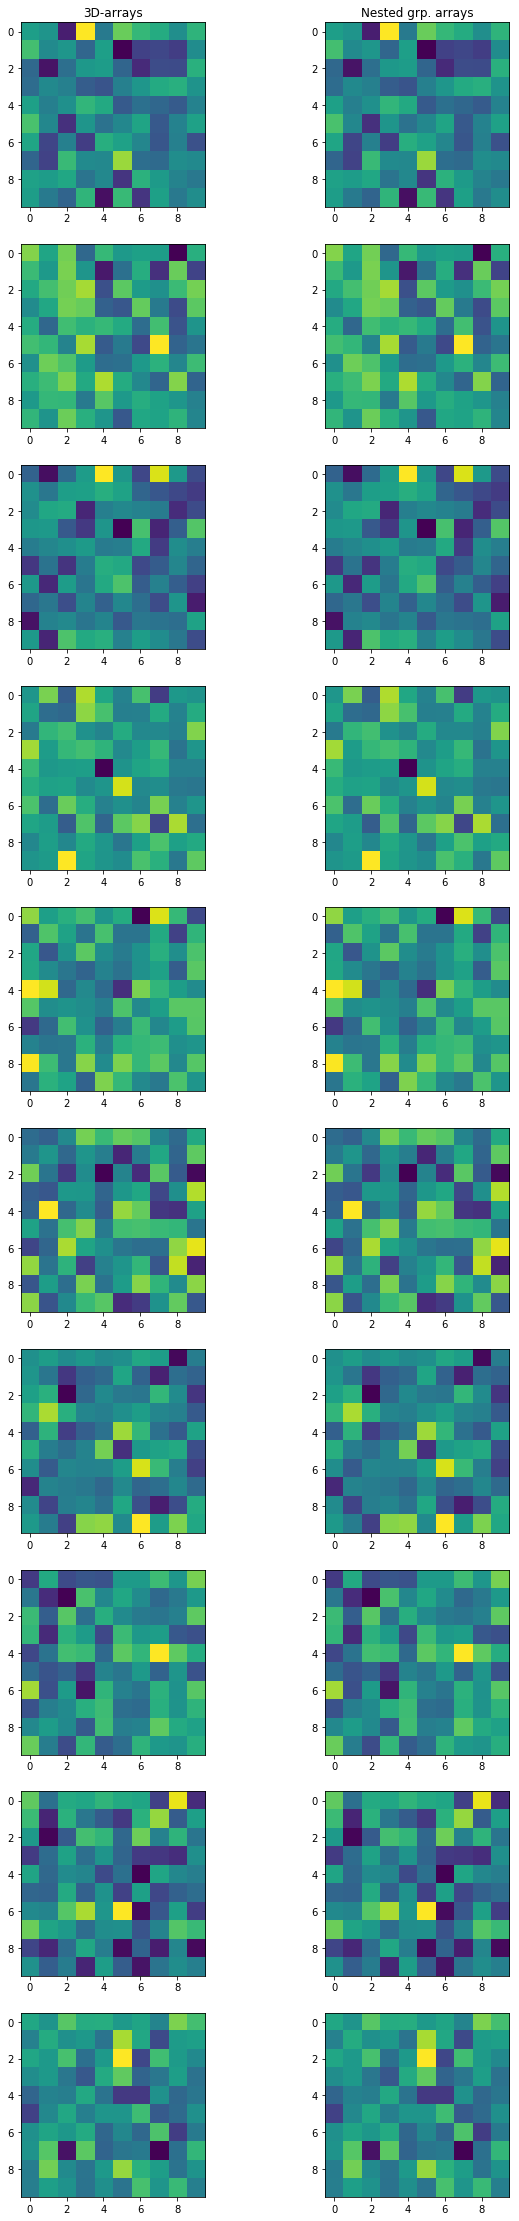

In [141]:

with h5py.File(fout_path, 'r') as fin:
    n_images = fin['images_3d'].shape[0]
    n_rws = min(10, numpy.ceil(n_images/2).astype('i8') )
    
    #
    #for k, (ky,vl) in enumerate([(ky,vl) for ky,vl in fin.items() if 'experiment_' in ky]):
    
    for k,im in enumerate(fin['images_3d']):
        if k%10==0:
            fg = plt.figure(figsize=(10, 4*n_rws))
        #
        #if im is None: 
        #    print('*** None!!!')
        #print('** ** index: {}'.format(1+2*(k%10)) )
        # 
        ax1 = plt.subplot( n_rws, 2, 1+2*(k%10) )
        ax1.imshow(im)
        #
        if 'experiment_{}'.format(k) in fin.keys():
            ax2 = plt.subplot( n_rws, 2, 2+2*(k%10))
            ax2.imshow(fin['experiment_{}'.format(k)]['image'])
        #
        if k%10==0:
            fg.axes[0].set_title('3D-arrays')
            fg.axes[1].set_title('Nested grp. arrays')
        #
